# Intro
- This is the first jupyter notebook for the EIA interhemispheric assymmetry (IHA) seen during different solar cycles
- TEC comparison during the March equinox is carried out for different years
    - Peaks of the north and south EIA are traced and compared

# Reading New TEC Data and Producing Output Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')
import functions


from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [2]:
functions = il.reload(functions)
month = 'june' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept':
    years_tot = list(range(2019, 2024))
else:
    years_tot = list(range(2021, 2025))
    
for year in tqdm(years_tot):
    
    print(year)

    
    # Reading Madrigal Cedar data for +- 21 days around March equinox of 2010-2024
    # Files in below scratch folder are obtained by using multiple file download 
    # command in ASCII format and then doing `gunzip file.gz`  
    path = '/home/pxv220016/scratch/Qingyu_Cesar_EIA/' + month + '_data/' + str(year) + '_' + month + '_' + phase + '/'
    files = os.listdir(path)
    files = [path + i for i in files]

    for f in files:
        if f[-4:] != '.txt':
            files.remove(f)

    '''
    for f in files:
        print(f)
    '''
    print(len(files))
    
    tec_g = []
    columns = ['GDLAT', 'GLON', 'TEC', 'DT']
    grnd_tec = pd.DataFrame(columns=columns)

    def process_file(f):
        # Read function passed continuously during multiple processing to quicken the process
        df = pd.read_csv(f, sep=r'\s+')
        d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
        df['DT'] = d
        # Dropping unnecassary columns from the Dataframe
        df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
        if 'GDALT' in df.columns:
            df = df.drop(['GDALT'], axis=1)
        df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
        return df    
    # Speeding the process by using parallel processing
    tec_g = p_map(process_file, files)  # Parallel processing with progress bar
    print('1')
    grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
    grnd_tec = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])


    # Reading the Kp index values for all the days and filtering undesired points where Kp > 3
    file = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_' + str(year) + '_' + month + '.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)
    grnd_tec0 = functions.kp_index_filtering(grnd_tec, kp)
    print('2')

    # Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
    t_start = dt.datetime.now() # just a timer
    with Pool(24) as pool:
        p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
    pool.close()
    pool.join()
    # Separating the data from output list 
    sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)
    t_total = dt.datetime.now() - t_start
    print(t_total)
    

    # Reordering the outputs and applying further conditions on magnetic coordinates
    grnd_temp = pd.DataFrame({'DT': sat_date, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt})
    grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
    grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

    
    # Writing the output into csv files for easy post processing
    grnd_tec2.to_csv('/home/pxv220016/scratch/Qingyu_Cesar_EIA/outputs/' + month + '/' + str(year) + '_' + month + '_' + phase + '.csv', index=False)


  0%|                                                     | 0/4 [00:00<?, ?it/s]

2021
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:17:02.089608


 25%|██████████▎                              | 1/4 [21:30<1:04:32, 1290.90s/it]

2022
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:45:02.297632


 50%|███████████████████▌                   | 2/4 [1:10:54<1:15:49, 2274.70s/it]

2023
43


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:16:45.958314


 75%|██████████████████████████████▊          | 3/4 [1:32:29<30:27, 1827.55s/it]

2024
43


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:13:38.309408


100%|█████████████████████████████████████████| 4/4 [1:50:24<00:00, 1656.20s/it]


In [5]:
f = '/home/pxv220016/scratch/Qingyu_Cesar_EIA/outputs/' + month + '/' + str(year) + '_' + month + '_' + phase + '.csv'
print(f)
grnd_tec2.to_csv(f, index=False)

/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/march/2011_march_equinox.csv


In [ ]:
functions = il.reload(functions)
month = 'march' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept':
    years_tot = list(range(2010, 2024))
else:
    years_tot = list(range(2010, 2025))

for year in tqdm(years_tot):
    
    print(year)

    
    # Reading Madrigal Cedar data for +- 21 days around March equinox of 2010-2024
    # Files in below scratch folder are obtained by using multiple file download 
    # command in ASCII format and then doing `gunzip file.gz`  
    path = '/home/pxv220016/scratch/Qingyu_Cesar_EIA/' + month + '_data/' + str(year) + '_' + month + '_' + phase + '/'
    files = os.listdir(path)
    files = [path + i for i in files]

    for f in files:
        if f[-4:] != '.txt':
            files.remove(f)

    '''
    for f in files:
        print(f)
    '''
    print(len(files))
    
    tec_g = []
    columns = ['GDLAT', 'GLON', 'TEC', 'DT']
    grnd_tec = pd.DataFrame(columns=columns)

    def process_file(f):
        # Read function passed continuously during multiple processing to quicken the process
        df = pd.read_csv(f, sep=r'\s+')
        d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
        df['DT'] = d
        # Dropping unnecassary columns from the Dataframe
        df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
        if 'GDALT' in df.columns:
            df = df.drop(['GDALT'], axis=1)
        df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
        return df    
    # Speeding the process by using parallel processing
    tec_g = p_map(process_file, files)  # Parallel processing with progress bar
    print('1')
    grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
    grnd_tec = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])


    # Reading the Kp index values for all the days and filtering undesired points where Kp > 3
    file = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_' + str(year) + '_' + month + '.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)
    grnd_tec0 = functions.kp_index_filtering(grnd_tec, kp)
    print('2')

    # Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
    t_start = dt.datetime.now() # just a timer
    with Pool(20) as pool:
        p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
    pool.close()
    pool.join()
    # Separating the data from output list 
    sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)
    t_total = dt.datetime.now() - t_start
    print(t_total)
    

    # Reordering the outputs and applying further conditions on magnetic coordinates
    grnd_temp = pd.DataFrame({'DT': sat_date, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt})
    grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
    grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

    
    # Writing the output into csv files for easy post processing
    grnd_tec2.to_csv('/home/pxv220016/scratch/Qingyu_Cesar_EIA/outputs/' + month + '/' + str(year) + '_' + month + '_' + phase + '.csv', index=False)


  0%|                                                    | 0/15 [00:00<?, ?it/s]

2010
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:07:25.077843


  7%|██▋                                      | 1/15 [09:27<2:12:19, 567.11s/it]

2011
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:06:54.732872


 13%|█████▍                                   | 2/15 [18:25<1:59:14, 550.35s/it]

2012
43


  0%|          | 0/43 [00:04<?, ?it/s]

1
2
0:09:35.800561


 20%|████████▏                                | 3/15 [30:45<2:07:23, 636.99s/it]

2013
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:15:20.688764


 27%|██████████▉                              | 4/15 [50:27<2:36:12, 852.04s/it]

2014
43


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:16:57.913425


 33%|████████████▋                         | 5/15 [1:12:29<2:50:15, 1021.57s/it]

2015
43


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:11:27.033129


 40%|███████████████▌                       | 6/15 [1:27:25<2:26:49, 978.89s/it]

2016
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:13:28.573566


 47%|██████████████████▏                    | 7/15 [1:44:31<2:12:33, 994.14s/it]

2017
43


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:09:03.928068


 53%|████████████████████▊                  | 8/15 [1:56:30<1:45:46, 906.61s/it]

2018
43


  0%|          | 0/43 [00:00<?, ?it/s]

1
2
0:16:21.601868


 60%|██████████████████████▊               | 9/15 [2:16:46<1:40:19, 1003.30s/it]

2019
43


IOStream.flush timed out


  0%|          | 0/43 [00:00<?, ?it/s]

1
2


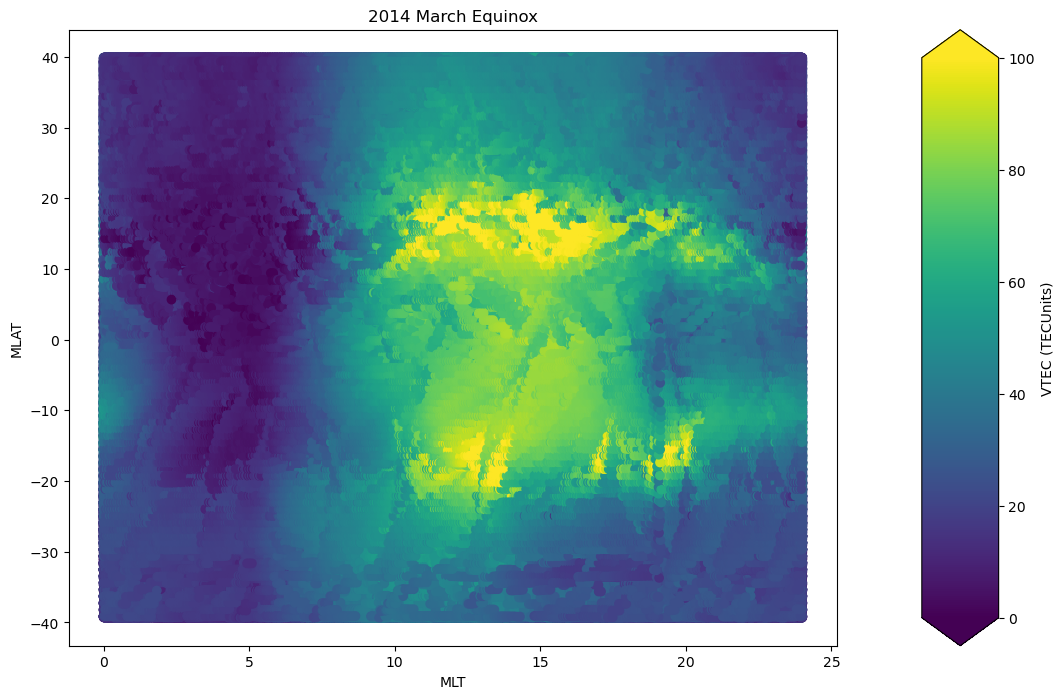

In [6]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(grnd_tec2.MLT, grnd_tec2.MLAT, c=grnd_tec2.TEC, vmax=100, vmin=0)
ax[0].set_title('2014 March Equinox')
ax[0].set_ylabel('MLAT')
ax[0].set_xlabel('MLT')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
fig.show()


# Reading Data Directly From Saved Output Files

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt
from scipy.signal import savgol_filter

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')

100%|███████████████████████████████████████████| 14/14 [03:34<00:00, 15.34s/it]


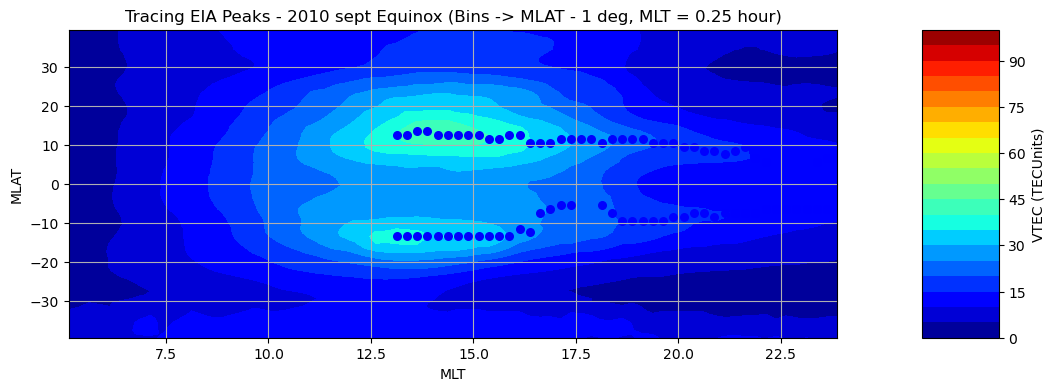

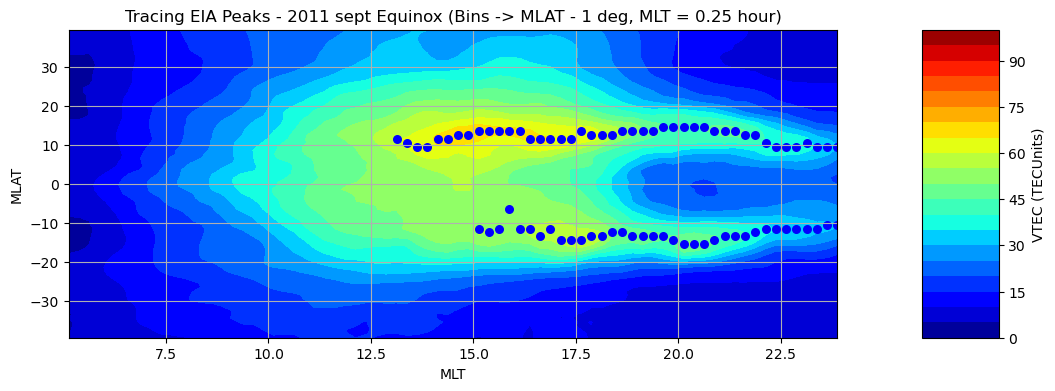

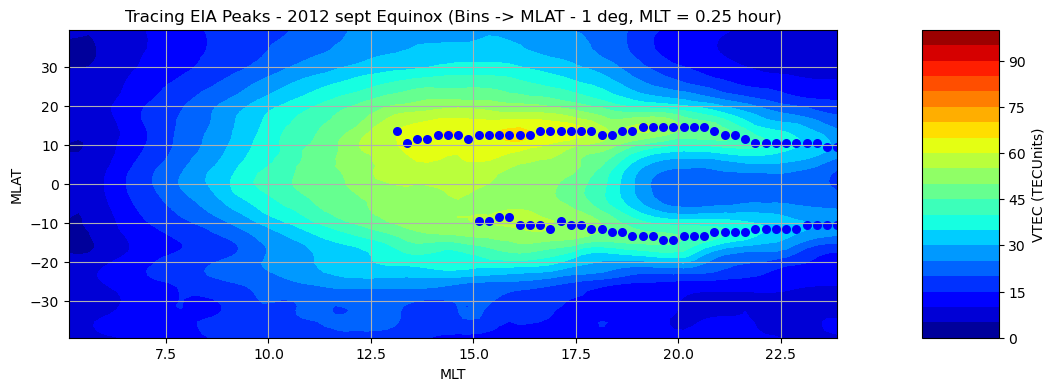

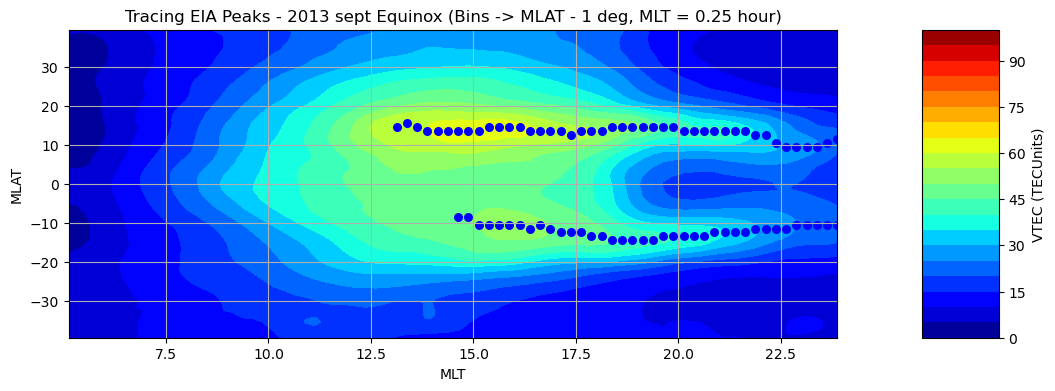

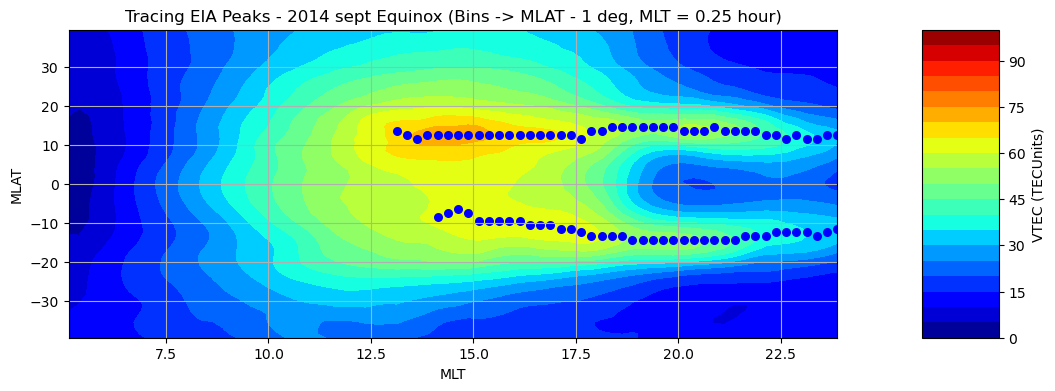

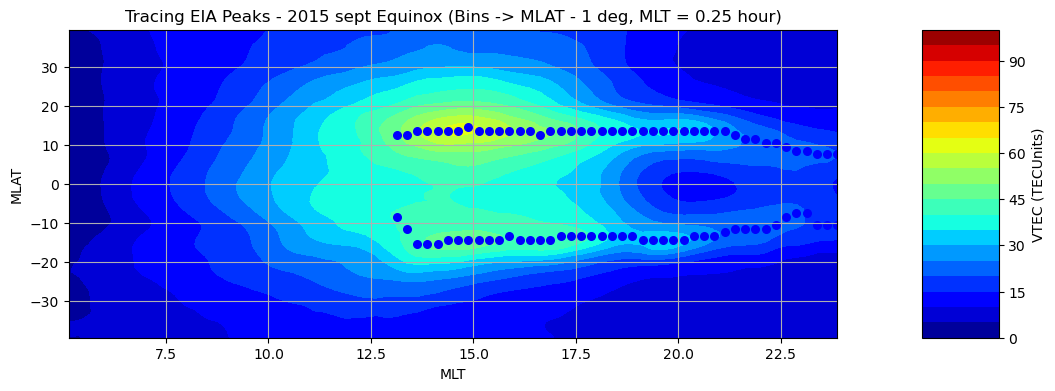

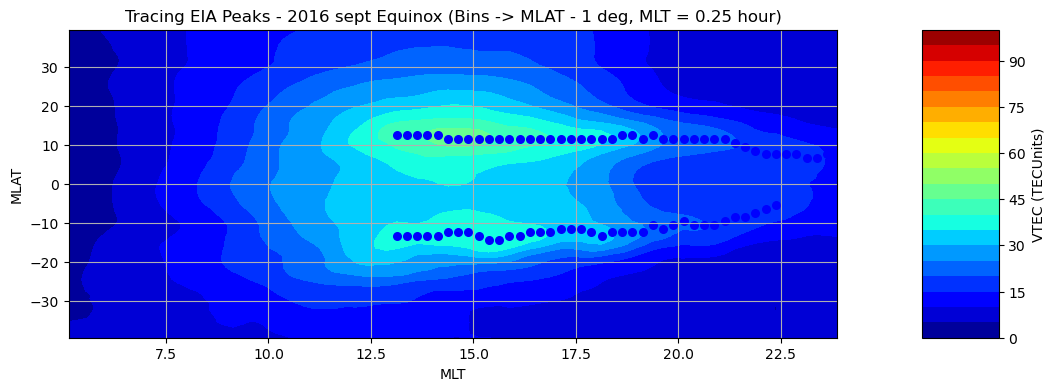

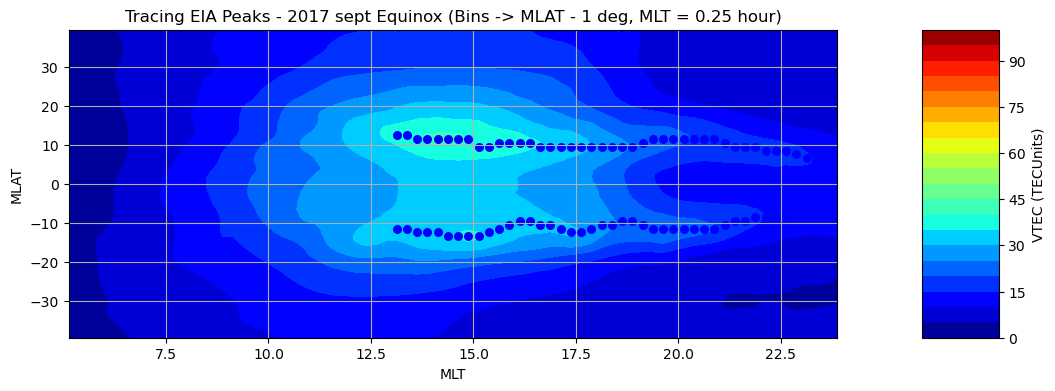

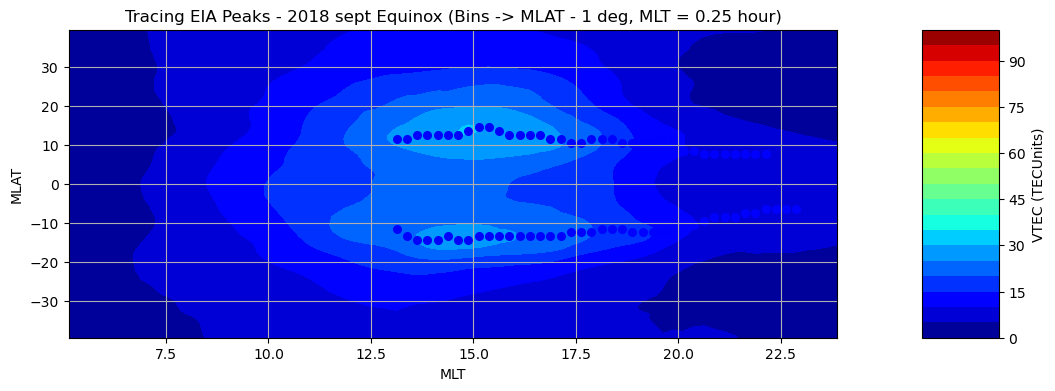

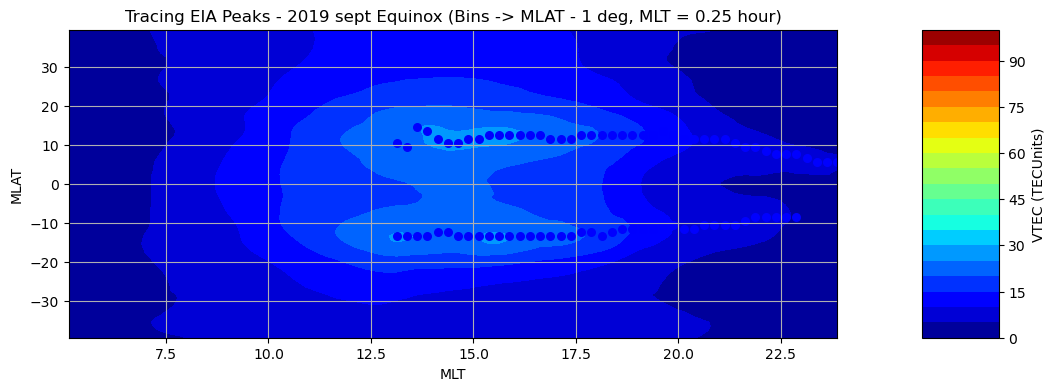

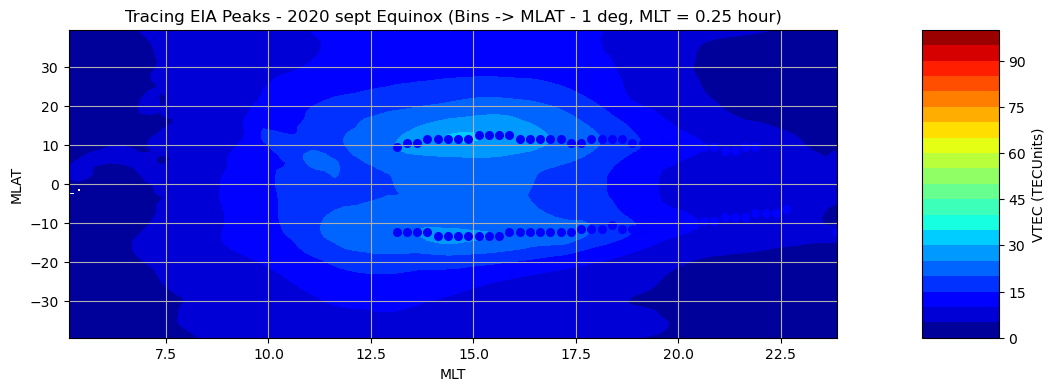

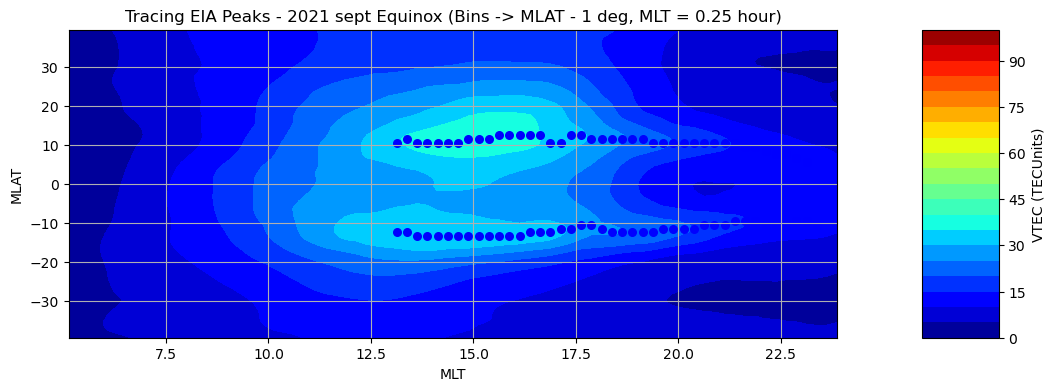

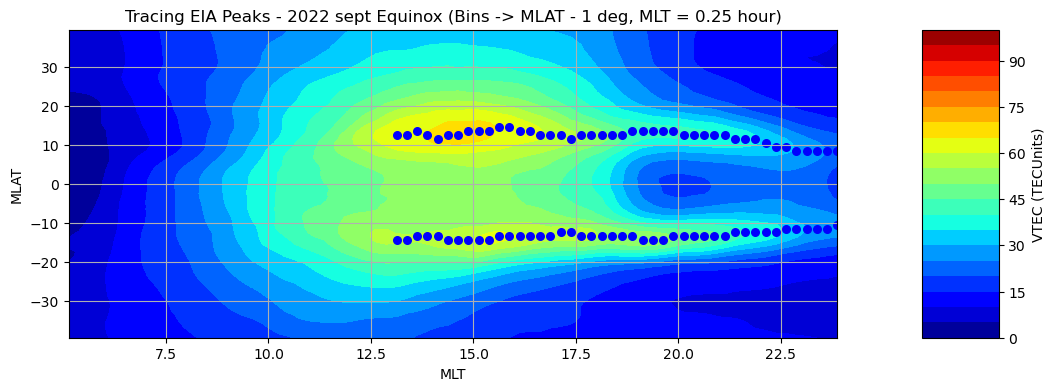

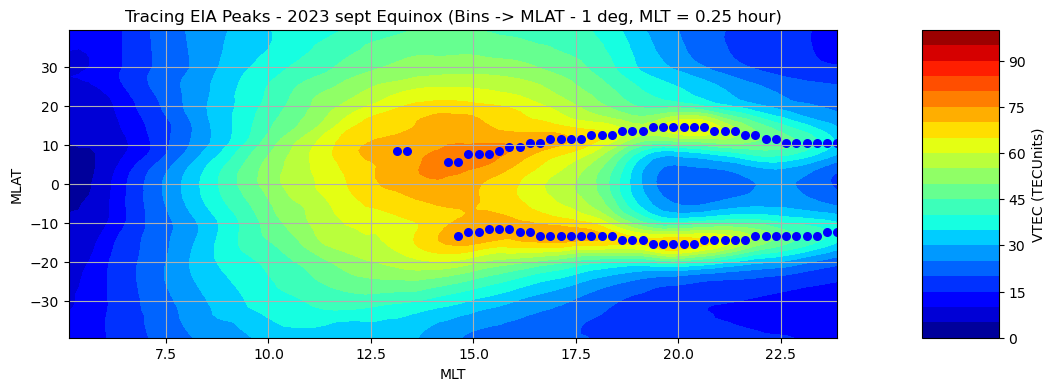

In [5]:
month = 'sept'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept':
    years = list(range(2010, 2024))
else:
    years = list(range(2021, 2025))


for year in tqdm(years):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv('/home/pxv220016/scratch/Qingyu_Cesar_EIA/outputs/' + month + '/' + str(year) + '_' + month + '_' + phase + '.csv')


    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(grnd_tec2['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    bins_mlt = pd.cut(grnd_tec2['MLT'], bins=pd.interval_range(start=0, end=24, freq=0.25))
    
    # Create a new DataFrame with the bins
    grnd_tec2['MLAT_b'] = bins_mlat
    grnd_tec2['MLT_b'] = bins_mlt
    
    # Group by the bins (MLAT_b (primary) and MLT_b (secondary)) and calculate the average of TEC
    result = grnd_tec2.groupby(['MLT_b', 'MLAT_b'])['TEC'].mean().reset_index()
    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result['MLAT_b'] = result['MLAT_b'].apply(lambda x: x.mid)
    result['MLT_b'] = result['MLT_b'].apply(lambda x: x.mid)
    result['MLAT_b'] = result['MLAT_b'].astype(float)
    result['MLT_b'] = result['MLT_b'].astype(float)


    result = result[result.MLT_b >= 5].reset_index(drop=True)
    
    
    filtered = []
    for t in result['MLT_b'].unique():
        result_f = result[result['MLT_b'] == t].reset_index(drop=True)
        fit = savgol_filter(np.array(result_f.TEC), 10, 2)
        filtered.extend(fit)
    result['TEC'] = filtered
    result = result.groupby(['MLAT_b', 'MLT_b']).sum().reset_index()
    
    
    # Identifying NH and SH peaks
    result_t = result[result.MLT_b >= 13].reset_index(drop=True)
    result_n = result_t[result_t.MLAT_b > 0].reset_index(drop=True)
    result_s = result_t[result_t.MLAT_b < 0].reset_index(drop=True)
    result_n = result_n.loc[result_n.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    result_s = result_s.loc[result_s.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    # Dropping the cases where the SH peak is not prominent and maxima appears to come at equator
    result_n.loc[result_n['MLAT_b'] < 5, 'TEC'] = np.nan
    result_s.loc[result_s['MLAT_b'] > -5, 'TEC'] = np.nan
    #print(result_s)
    
    i = 100*2*(result_n.TEC - result_s.TEC)/(result_n.TEC + result_s.TEC)
    result_ind = pd.DataFrame({'mlat_n': result_n.MLAT_b, 'tec_n': result_n.TEC, 'mlat_s': result_s.MLAT_b, 'tec_s': result_s.TEC, 'mlt': result_n.MLT_b, 'asy': i})
    result_ind.to_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/' + month + '/asy_' + str(year) + '_' + month + '.csv', index=False)

    X, Y = np.meshgrid(result.MLT_b.unique(), result.MLAT_b.unique())
    Z = result.TEC.values.reshape(X.shape)
    if np.max(Z) <= 40:
        contour_levels = list(range(0, 40, 2.5))
    else:
        contour_levels = list(range(0, 101, 5))

    # Creating new dataframe to remove rows where TEC= NaN
    result_n = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_n': result_ind.mlat_n, 'tec_n': result_ind.tec_n})
    result_n = result_n.dropna(subset='tec_n')
    result_s = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_s': result_ind.mlat_s, 'tec_s': result_ind.tec_s})
    result_s = result_s.dropna(subset='tec_s')

    
    fig = plt.figure(figsize=(12,4))
    specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
    ax = []
    ax.append(fig.add_subplot(specs[0, 0]))
    c = ax[0].contourf(X, Y, Z, levels=contour_levels, cmap = 'jet')
    ax[0].scatter(result_n.mlt, result_n.mlat_n, c='b', s=30)
    ax[0].scatter(result_s.mlt, result_s.mlat_s, c='b', s=30)
    ax[0].set_title('Tracing EIA Peaks - ' + str(year) + ' ' + month + ' Equinox (Bins -> MLAT - 1 deg, MLT = 0.25 hour)')
    ax[0].set_ylabel('MLAT')
    ax[0].set_xlabel('MLT')
    ax[0].grid(True)

    # Set ylim conditionally
    if np.max(Z) <= 40:
        ax[0].set_ylim(top=40)
    
    cbar_ax = fig.add_subplot(specs[0,1])
    cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
    fig.savefig('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/'  + month + '/eia_peaks_'  + month + '_' + str(year) + '.jpg')
    fig.show()




# Comparing Asymmetry Index

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')

In [7]:
month = 'march' # 'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept':
    years = [2011, 2012, 2013, 2014, 2022, 2023]
else:
    years = [2011, 2012, 2013, 2014, 2022, 2023, 2024]


asy_ind = []

for y in years:
    f = pd.read_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/'  + month + '/asy_' +str(y) + '_'  + month + '.csv')
    asy_ind.append(f)

In [8]:
if month == 'march':
    solar_cyc = [[list(range(2011, 2015))], [list(range(2022, 2024))]]
else:
    solar_cyc = [[list(range(2011, 2015))], [list(range(2022, 2025))]]


sc = ['Baseline SC 24', 'Baseline SC 25']

sc_base = []

for s in tqdm(solar_cyc):
    for periods in s:
        columns = ['mlt', 'asy']
        baseline = pd.DataFrame(columns=columns)

        for p in periods:
            a = pd.read_csv('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/'  + month + '/asy_' + str(p) + '_'  + month + '.csv')
            a = a.drop(['mlat_n', 'mlat_s', 'tec_n', 'tec_s'], axis=1)
            #a = a.dropna(subset = 'asy')
            baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
        
        baseline = baseline.sort_values(by=['mlt'], ascending=[True])
        bins_mlt = pd.cut(baseline['mlt'], bins=pd.interval_range(start=0, end=24, freq=0.75))
        baseline['mlt'] = bins_mlt
        baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index()
        baseline['mlt'] = baseline['mlt'].apply(lambda x: x.mid)
        baseline['mlt'] = baseline['mlt'].astype(float)
        baseline.dropna(inplace=True)
        print(baseline)
        break
    sc_base.append(baseline)


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 41.58it/s]

       mlt        asy
18  13.875  14.777656
19  14.625  15.304575
20  15.375  15.666566
21  16.125  18.079325
22  16.875  11.412263
23  17.625   4.885283
24  18.375  -1.512205
25  19.125  -8.707983
26  19.875  -8.627716
27  20.625  -2.346952
28  21.375   7.824172
29  22.125  16.129594
30  22.875  13.840178
31  23.625   1.030073
       mlt        asy
17  13.125   1.411737
18  13.875  -0.374105
19  14.625  -3.380038
20  15.375  -7.670587
21  16.125  -9.638744
22  16.875  -7.503023
23  17.625  -5.673831
24  18.375  -6.698150
25  19.125 -16.409507
26  19.875 -17.031146
27  20.625 -12.177124
28  21.375  -1.995526
29  22.125   0.249463
30  22.875  -1.356695
31  23.625  -9.639736


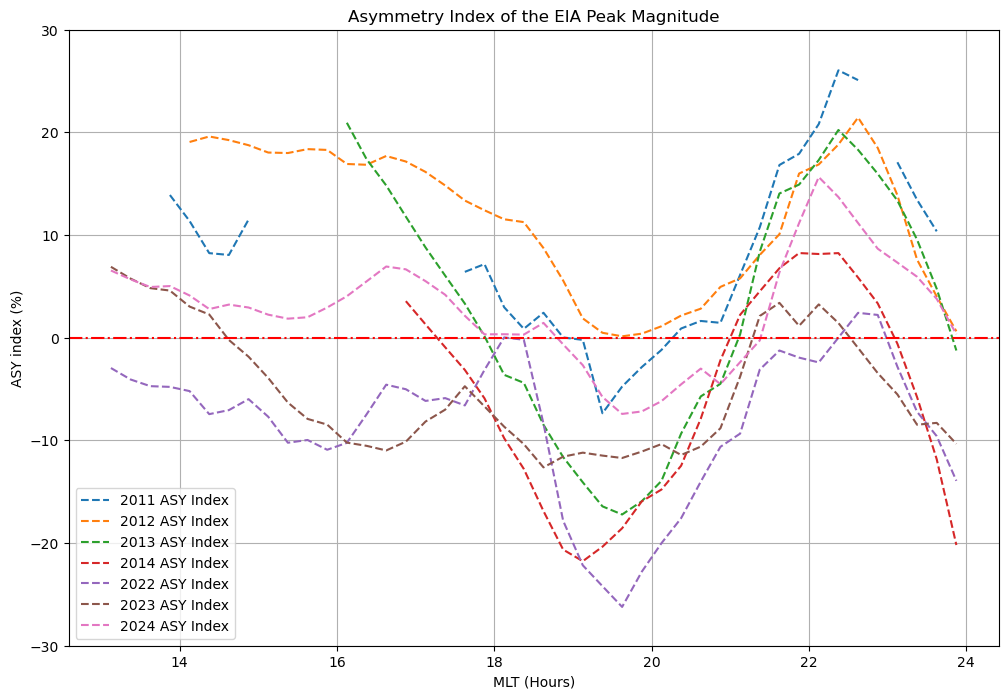

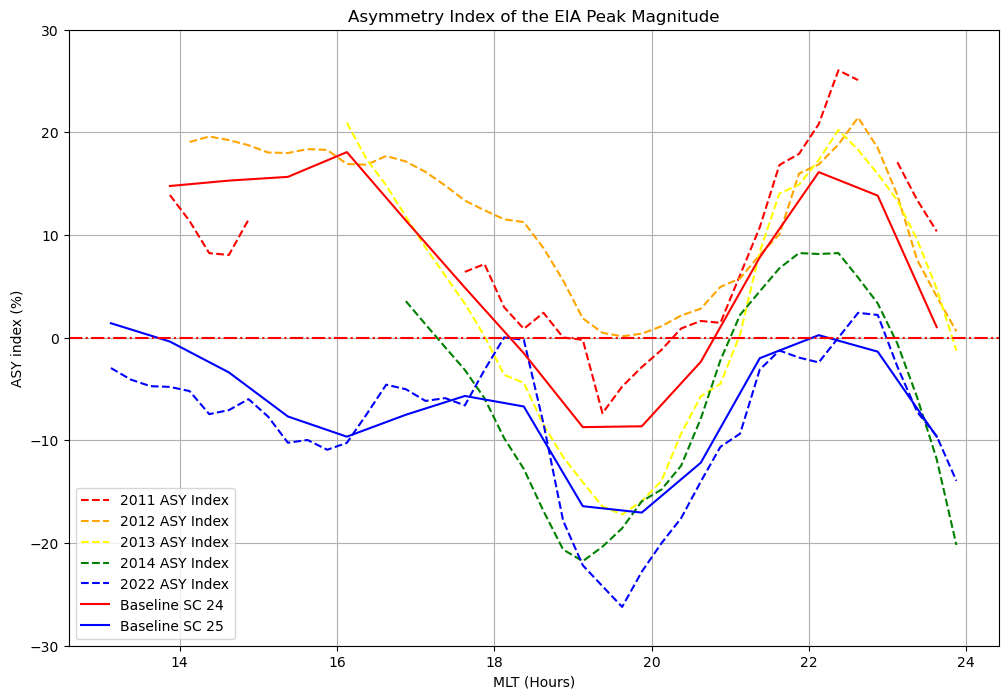

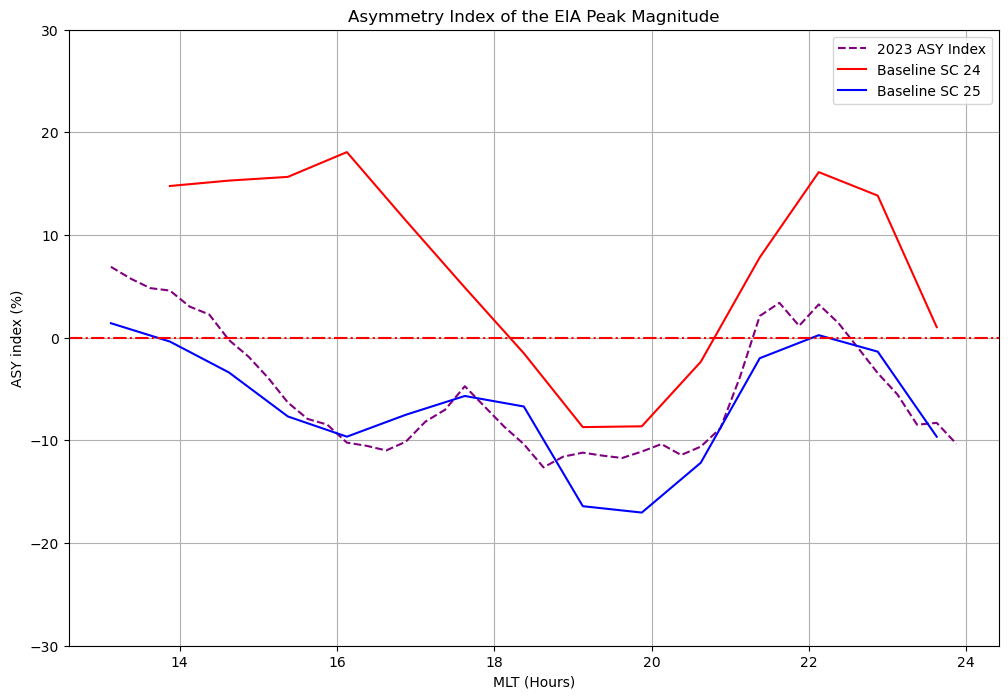

In [9]:
fig = plt.figure(figsize=(12,8))
for a, y in zip(asy_ind, years):
    if month == 'sept' and y == 2024:
        break
    plt.plot(a.mlt, a.asy, linestyle = '--', label=str(y) + ' ASY Index')
plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_ind/'  + month + '/asy_all_'  + month + '.jpg')
fig.show()


'''
fig = plt.figure(figsize=(12,8))
a_sc = [asy_ind[0], asy_ind[1], asy_ind[2], asy_ind[-1]]
y_sc = [years[0], years[1], years[2], years[-1]]
for a, y in zip(a_sc, y_sc):
    if month == 'sept' and y == 2023:
        break
    plt.plot(a.mlt, a.asy, linestyle = '--', label=str(y) + ' ASY Index')
plt.plot(asy_ind[3].mlt, asy_ind[3].asy, label='2022 ASY Index', c='black')
plt.plot(asy_ind[4].mlt, asy_ind[4].asy, label='2023 ASY Index', c='purple')

#color_sc = ['red', 'blue']
#for b, s, cs in zip(sc_base, sc, color_sc):
#    plt.plot(b.mlt, b.asy, label = s, c=cs)

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_ind/'  + month + '/asy_all_'  + month + '.jpg')
fig.show()
'''


color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

fig = plt.figure(figsize=(12,8))
for a, y, c in zip(asy_ind[:5], years[:5], color[:5]):
    plt.plot(a.mlt, a.asy, linestyle = '--', label=str(y) + ' ASY Index', c = c)
color_sc = ['red', 'blue']
plt.plot(sc_base[0].mlt, sc_base[0].asy, label = sc[0], c=color_sc[0])
plt.plot(sc_base[1].mlt, sc_base[1].asy, label = sc[1], c=color_sc[1])
plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_ind/'  + month + '/asy_sc24_'  + month + '.jpg')
fig.show()


fig = plt.figure(figsize=(12,8))
for a, y, c in zip(asy_ind[5:], years[5:], color[5:]):
    plt.plot(a.mlt, a.asy, linestyle = '--', label=str(y) + ' ASY Index', c = c)
color_sc = ['red', 'blue']
plt.plot(sc_base[0].mlt, sc_base[0].asy, label = sc[0], c=color_sc[0])
plt.plot(sc_base[1].mlt, sc_base[1].asy, label = sc[1], c=color_sc[1])
plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_ind/'  + month + '/asy_sc25_'  + month + '.jpg')
fig.show()


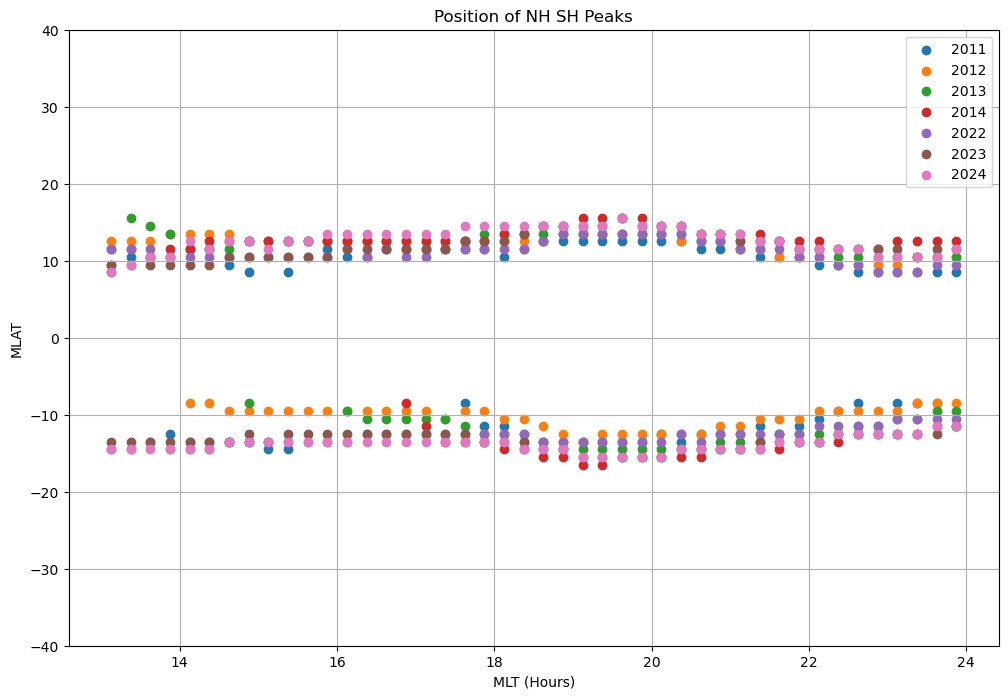

In [10]:

fig = plt.figure(figsize=(12,8))
for a, y in zip(asy_ind, years):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
    time = list(a_n.mlt) + list(a_s.mlt)
    plt.scatter(time, mlat, label=str(y))
'''
color_sc = ['red', 'blue']
for b, s, cs in zip(sc_base, sc, color_sc):
    plt.plot(b.mlt, b.asy, label = s, c=cs)
'''
plt.ylim(-20,20)
plt.legend()
plt.title('Position of NH SH Peaks')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/asy_ind/'  + month + '/pos_all_'  + month + '.jpg')
fig.show()



# F10.7 Comparison for March 2023 and 2024

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt

import sys
sys.path.append('../')
sys.path.append('/home/pxv220016/prasoon/data/sat_interp_repo/repo2/prasoon_utility_programs')

In [39]:
functions = il.reload(functions)
f107_years = [2023, 2024]
month = 'march'

path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Qingyu_Cesar_EIA_IHA/outputs/'  + month + '/f107_' + month + '_'

columns = ['Year', 'DOY', 'Hour', 'f10_7']
f107 = pd.DataFrame(columns = columns)

for y in f107_years:
    file = path + str(y) + '.txt'
    df_f107 = pd.read_csv(file, sep=r'\s+')
    print(y, 'year -> Mean =', sum(df_f107.f10_7)/len(df_f107.f10_7), 'and Median =', np.median(df_f107.f10_7))
print('\nBoth mean and median of F10.7 index during ' + month + ' equinox for 2023 is higher than 2024.')

2023 year -> Mean = 150.87441860465202 and Median = 148.1
2024 year -> Mean = 146.01395348837212 and Median = 137.6

Both mean and median of F10.7 index during March equinox for 2023 is higher than 2024.


# Position Comparison for MLT and MLAT